In [ ]:
!pip install guppy3

## Import modules

In [ ]:
import numpy as np

# to get and read data
import os
from scipy.io import loadmat

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# for clustering
from sklearn.cluster import KMeans

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f
from char_modules import preprocess_f, plotting_f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import importlib
importlib.reload(patches_f)

<module 'common_modules.patches_f' from '/content/drive/MyDrive/project/common_modules/patches_f.py'>

## Get and Read data

get data

In [ ]:
data_f.download_file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat",
                        saveAs = "mixoutALL_shifted.mat")

#load the file
mat = loadmat('mixoutALL_shifted.mat')
print(mat.keys())

file already exists
dict_keys(['__header__', '__version__', '__globals__', 'consts', 'mixout'])


read data

In [ ]:
consts = mat['consts'][0][0]
#print(consts)

classes = [char[0] for char in consts[3][0]]
print(classes)
print('number of classes :',len(classes))

#subtract 1 since np array indexing is from 0
labels = consts[4][0] - 1
inputs = mat['mixout'][0]

train_inputs, test_inputs, train_labels, test_labels = data_f.train_test_split(inputs, labels, test_size=0.25, random_state=0)

train_labels = np.array([int(label) for label in train_labels])
test_labels = np.array([int(label) for label in test_labels])

#append zeroes to resize
train_inputs, target_len = patches_f.append_defaults(train_inputs, 206)
test_inputs, _ = patches_f.append_defaults(test_inputs, 206)

train_data = list(zip(train_inputs, train_labels))
test_data = list(zip(test_inputs, test_labels))

['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
number of classes : 20


max length = 205


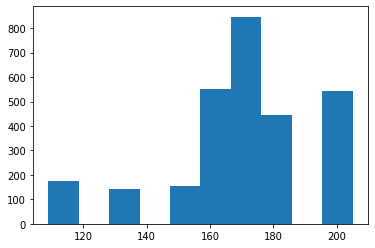

In [ ]:
# distribution of sample lenghts
lengths = []

for sample in inputs:
  input = sample[0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

## Patches

In [ ]:
kwargs = {'window_size':20, 'stride':10}

kwargs['data'] = train_data
patch_train_inputs, patch_train_labels, patch_train_indexes = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
patch_test_inputs, patch_test_labels, patch_test_indexes = patches_f.dataToPatches(**kwargs)

### visualize patches

a
original sample


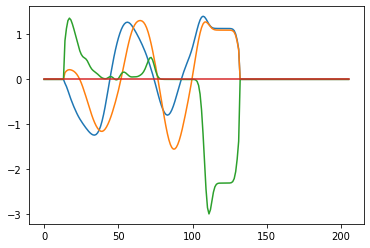

19 patches


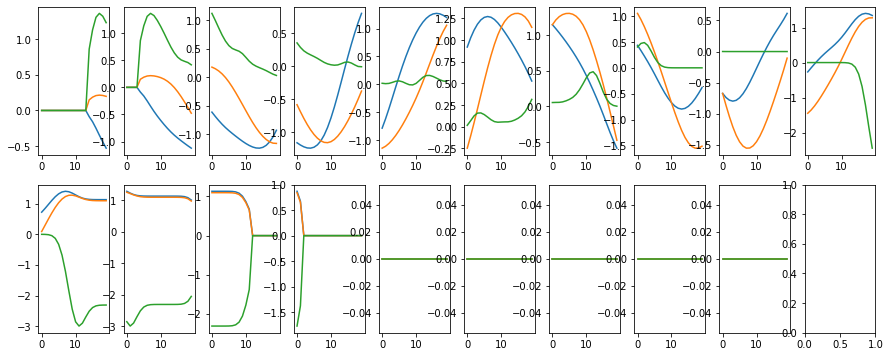

In [ ]:
plotting_f.plotTimeSeries(train_data, patch_train_indexes, patch_train_inputs, char='a', index=0)

a
original sample


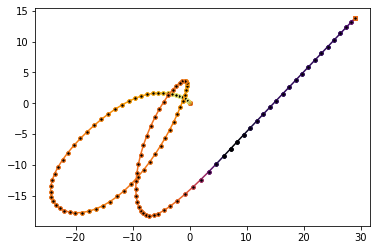

19 patches


/content/drive/MyDrive/project/char_modules/plotting_f.py:19: RuntimeWarning: invalid value encountered in true_divide
  color = (force - np.min(force)) / (np.max(force)-np.min(force))


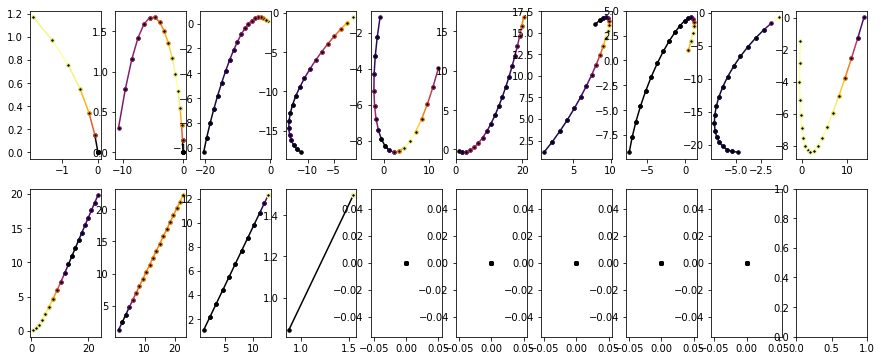

In [ ]:
plotting_f.plotChar(train_data, patch_train_indexes, patch_train_inputs, char='a', index=0)

## Clustering

In [ ]:
# flatten inputs to 2d array
train_inputs2d = clusters_f.flatten_to_2d(train_inputs)

plot silhoutte index for number of cluster 2 and 20

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "



runtime:  3408.766349554062

memory consumption:
Partition of a set of 920176 objects. Total size = 1110395075 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   3212   0 996950409  90 996950409  90 numpy.ndarray
     1 238756  26 34132257   3 1031082666  93 str
     2 222729  24 17695184   2 1048777850  94 tuple
     3  92487  10  7324582   1 1056102432  95 bytes
     4  47019   5  6803528   1 1062905960  96 types.CodeType
     5  18253   2  6581120   1 1069487080  96 dict (no owner)
     6  44550   5  6058800   1 1075545880  97 function
     7   5637   1  5498016   0 1081043896  97 type
     8  61098   7  4399056   0 1085442952  98 torch.Tensor
     9   2345   0  3392280   0 1088835232  98 dict of module
<2271 more rows. Type e.g. '_.more' to view.>



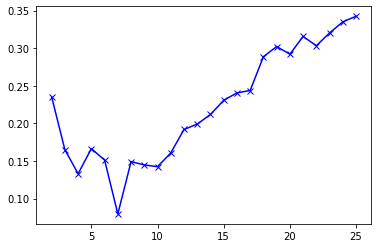

 n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.235026  3017.100372   2.196952  0.000960     0.010816   0.010956    0.207936
          3    0.164824  2948.814726   2.211393  0.002671     0.020436   0.020688    0.187951
          4    0.132977  2976.645622   2.227971  0.004847     0.023733   0.024076    0.164276
          5    0.166398  2963.983549   2.252780  0.010050     0.035263   0.035690    0.156365
          6    0.151103  2911.027271   2.011092  0.010297     0.043278   0.043788    0.147741
          7    0.079501  2914.426489   2.051750  0.012615     0.046603   0.047188    0.135943
          8    0.149058  2995.438583   1.935959  0.012703     0.045555   0.046211    0.123652
          9    0.144673  2871.602128   1.861532  0.014868     0.057627   0.058364    0.129498
         10    0.142328  2801.416299   1.813801  0.013245     0.045850   0.046654    0.112865
         11    0.160579  2818.421480   1.822056  0.015252   

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "KMeans", list(range(2,26)), train_labels)   #list(range(2,31))

### visualize cluster centers


cluster centers visualized


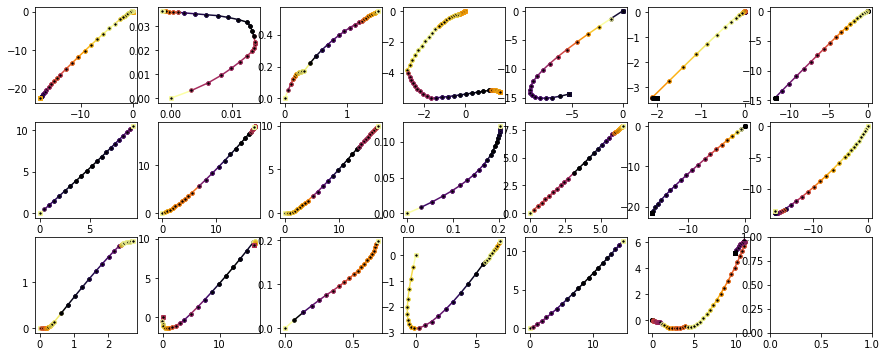

In [ ]:
#kmeans_centers = clusters_f.form_clusters(train_inputs2d, "KMeans", [20], train_labels)
kmeans = KMeans(n_clusters=20, random_state=0).fit(train_inputs2d)
kmeans_centers = kmeans.cluster_centers_

print("\ncluster centers visualized")
plotting_f.plotClusters(kmeans_centers, sample_shape)

## Neural Network

### define network

In [ ]:
inp_size = 206; c0 = 4;   # c0 = 4 if indicator channel else 3
k_conv = 3; k_pool = 2; c1 = 8; c2 = 16; c3 = 32;

print("initial size  of  sample = %d x %d" % (c0,inp_size))
conv1_outSize = inp_size-(k_conv-1)
print("output  size after conv1 = %d x %d" % (c1,conv1_outSize))
pool1_outSize = np.floor((conv1_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool1 = %d x %d" % (c1,pool1_outSize))

conv2_outSize = pool1_outSize-(k_conv-1)
print("output  size after conv2 = %d x %d" % (c2,conv2_outSize))
pool2_outSize = np.floor((conv2_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool2 = %d x %d" % (c2,pool2_outSize))

conv3_outSize = pool2_outSize-(k_conv-1)
print("output  size after conv3 = %d x %d" % (c3,conv3_outSize))
pool3_outSize = np.floor((conv3_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool3 = %d x %d" % (c3,pool3_outSize))

initial size  of  sample = 4 x 206
output  size after conv1 = 8 x 204
output  size after pool1 = 8 x 102
output  size after conv2 = 16 x 100
output  size after pool2 = 16 x 50
output  size after conv3 = 32 x 48
output  size after pool3 = 32 x 24


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 8, 3)
        self.conv2 = nn.Conv1d(8, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(768, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def latent(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [ ]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                              test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [ ]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')

### train network

epoch: 15, train loss: 0.377, val loss: 0.381
epoch: 30, train loss: 0.122, val loss: 0.173
epoch: 45, train loss: 0.064, val loss: 0.149
epoch: 60, train loss: 0.027, val loss: 0.148
epoch: 75, train loss: 0.015, val loss: 0.141
Finished Training


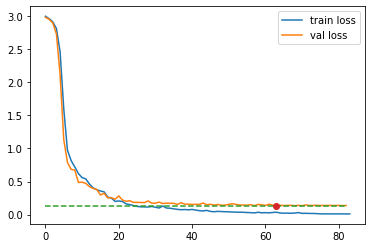

In [ ]:
best_params = network_f.trainNet(net,criterion,optimizer, scheduler,
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [ ]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
network_f.evaluate(net,train_inputs,train_labels,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_inputs,test_labels,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.9926    1.0000    0.9963       134
           b     0.9541    1.0000    0.9765       104
           c     1.0000    1.0000    1.0000       110
           d     0.9919    0.9919    0.9919       123
           e     1.0000    0.9932    0.9966       146
           g     1.0000    1.0000    1.0000        97
           h     0.9072    0.9778    0.9412        90
           l     0.9919    1.0000    0.9960       123
           m     0.9885    0.9885    0.9885        87
           n     0.9570    0.9082    0.9319        98
           o     0.9912    0.9912    0.9912       113
           p     1.0000    0.9368    0.9674        95
           q     1.0000    0.9889    0.9944        90
           r     0.9884    0.9551    0.9714        89
           s     0.9894    1.0000    0.9947        93
           u     0.9908    1.0000    0.9954       108
           v     0.9825    0.9912    0.9868       113
           w     0.9663   


              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000        37
           b     0.9000    0.9730    0.9351        37
           c     0.9697    1.0000    0.9846        32
           d     1.0000    1.0000    1.0000        34
           e     0.9750    0.9750    0.9750        40
           g     0.9535    1.0000    0.9762        41
           h     0.8780    0.9730    0.9231        37
           l     1.0000    1.0000    1.0000        51
           m     0.9737    0.9737    0.9737        38
           n     1.0000    0.7812    0.8772        32
           o     0.9032    1.0000    0.9492        28
           p     0.9697    0.8889    0.9275        36
           q     0.9688    0.9118    0.9394        34
           r     0.9286    0.8667    0.8966        30
           s     1.0000    0.9750    0.9873        40
           u     0.9583    1.0000    0.9787        23
           v     0.9545    1.0000    0.9767        42
           w     0.9667   

## Latent Representation

### extract and cluster latent representation from the trained network for patches

In [ ]:
latentPatch_train_inputs = network_f.netOutput(net, patch_train_inputs, type="latent")
latentPatch_test_inputs = network_f.netOutput(net, patch_test_inputs, type="latent")

# flatten inputs to 2d array
latentPatch_train_inputs2d = clusters_f.flatten_to_2d(latentPatch_train_inputs)
latentPatch_test_inputs2d = clusters_f.flatten_to_2d(latentPatch_test_inputs)

In [ ]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(latentPatch_train_inputs2d)
kmeans_train_labels = kmeans.labels_
kmeans_test_labels = kmeans.predict(latentPatch_test_inputs2d)

kmeans_train_labels = np.array([int(label) for label in kmeans_train_labels])
kmeans_test_labels = np.array([int(label) for label in kmeans_test_labels])

create dataset and dataloader

In [ ]:
train_loader, val_loader, test_loader = data_f.createLoaders(patch_train_inputs, kmeans_train_labels,
                                                              patch_test_inputs, kmeans_test_labels,
                                                              batch_size=32)

### create network

In [ ]:
net2 = Net().to(device)

optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.049, val loss: 0.043
epoch: 30, train loss: 0.035, val loss: 0.049
epoch: 45, train loss: 0.030, val loss: 0.033
epoch: 60, train loss: 0.027, val loss: 0.027
Finished Training


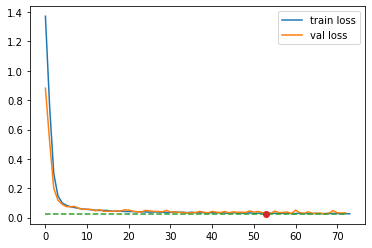

In [ ]:
best_params = network_f.trainNet(net2,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [ ]:
net2.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
network_f.evaluate(net2,patch_train_inputs,kmeans_train_labels)
print("evaluation results on test data")
network_f.evaluate(net2,patch_test_inputs,kmeans_test_labels)

evaluation results on train data



              precision    recall  f1-score   support

           0     0.9978    0.9960    0.9969     25425
           1     0.9797    0.9864    0.9830      1028
           2     0.9666    0.9936    0.9799       933
           3     0.9929    0.9947    0.9938       564
           4     0.9768    0.9736    0.9752       303
           5     0.9973    0.9866    0.9919       373
           6     0.9955    0.9928    0.9942      1802
           7     0.9896    0.9727    0.9811      1465
           8     0.9898    0.9932    0.9915       292
           9     0.9988    0.9645    0.9813       844
          10     0.9889    0.9536    0.9709       280
          11     0.9739    0.9989    0.9863       935
          12     0.9944    0.9972    0.9958       356
          13     1.0000    0.9606    0.9799       431
          14     0.9630    0.9964    0.9794       549
          15     0.9866    0.9957    0.9912      1409
          16     0.9578    0.9849    0.9712      1128
          17     0.9840   


              precision    recall  f1-score   support

           0     0.9972    0.9939    0.9955      8533
           1     0.9888    0.9860    0.9874       357
           2     0.9383    0.9931    0.9649       291
           3     0.9877    0.9756    0.9816       164
           4     0.9881    0.9540    0.9708        87
           5     0.9907    0.9815    0.9860       108
           6     0.9885    0.9918    0.9902       609
           7     0.9795    0.9656    0.9725       494
           8     1.0000    0.9762    0.9880        84
           9     0.9921    0.9691    0.9805       259
          10     0.9810    0.9450    0.9626       109
          11     0.9779    0.9968    0.9873       311
          12     0.9905    0.9905    0.9905       105
          13     0.9939    0.9702    0.9819       168
          14     0.9471    0.9949    0.9704       198
          15     0.9719    0.9825    0.9772       458
          16     0.9468    0.9854    0.9657       343
          17     0.9775   

# Model based on clusterfit predictions

In [ ]:
clustFitPatch_train_inputs = network_f.netOutput(net, patch_train_inputs)
clustFitPatch_test_inputs = network_f.netOutput(net, patch_test_inputs)

In [ ]:
def mergePatches(inputs, patchesPerSample):

  merged = []
  for index in range(0,len(inputs),patchesPerSample):
    input1 = np.array([x[0] for x in inputs[index : index+patchesPerSample]])
    input1 = np.transpose(input1)
    merged.append(input1)

  return np.array(merged)

In [ ]:
# 19 patches for every sample
#print(patch_train_indexes[0:20])

clustFit_train_inputs = mergePatches(clustFitPatch_train_inputs,19)
clustFit_test_inputs = mergePatches(clustFitPatch_test_inputs,19)

### define network

In [ ]:
 class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 20 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(20, 8, 3)
        self.conv2 = nn.Conv1d(8, 16, 3)
  
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(48, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [ ]:
train_loader, val_loader, test_loader = data_f.createLoaders(clustFit_train_inputs, train_labels,
                                                              clustFit_test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [ ]:
net3 = Net().to(device)

optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.233, val loss: 0.264
epoch: 30, train loss: 0.125, val loss: 0.209
epoch: 45, train loss: 0.081, val loss: 0.150
epoch: 60, train loss: 0.051, val loss: 0.168
epoch: 75, train loss: 0.043, val loss: 0.145
Finished Training


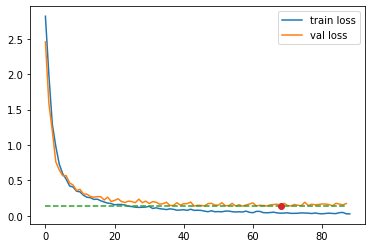

In [ ]:
best_params = network_f.trainNet(net3,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [ ]:
net3.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
network_f.evaluate(net3,clustFit_train_inputs,train_labels)
print("evaluation results on test data")
network_f.evaluate(net3,clustFit_test_inputs,test_labels)

evaluation results on train data



              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       134
           1     0.9712    0.9712    0.9712       104
           2     1.0000    1.0000    1.0000       110
           3     0.9919    1.0000    0.9960       123
           4     0.9932    1.0000    0.9966       146
           5     1.0000    1.0000    1.0000        97
           6     0.9348    0.9556    0.9451        90
           7     0.9919    1.0000    0.9960       123
           8     0.9885    0.9885    0.9885        87
           9     0.9381    0.9286    0.9333        98
          10     0.9912    0.9912    0.9912       113
          11     0.9684    0.9684    0.9684        95
          12     1.0000    0.9778    0.9888        90
          13     0.9885    0.9663    0.9773        89
          14     0.9894    1.0000    0.9947        93
          15     0.9818    1.0000    0.9908       108
          16     0.9825    0.9912    0.9868       113
          17     0.9884   


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        37
           1     0.8684    0.8919    0.8800        37
           2     1.0000    1.0000    1.0000        32
           3     0.9714    1.0000    0.9855        34
           4     1.0000    1.0000    1.0000        40
           5     1.0000    0.9756    0.9877        41
           6     0.8919    0.8919    0.8919        37
           7     0.9808    1.0000    0.9903        51
           8     0.9737    0.9737    0.9737        38
           9     0.8621    0.7812    0.8197        32
          10     0.9655    1.0000    0.9825        28
          11     0.8649    0.8889    0.8767        36
          12     0.9706    0.9706    0.9706        34
          13     0.9333    0.9333    0.9333        30
          14     1.0000    0.9750    0.9873        40
          15     0.9583    1.0000    0.9787        23
          16     0.9302    0.9524    0.9412        42
          17     0.9333   